# Use OSMnx to create and analyze a NetworkX street network

In [1]:
import osmnx as ox, networkx as nx, pandas as pd
%matplotlib inline
ox.config(log_file=True, log_console=True, use_cache=True)

## Calculate basic street network metrics

In [2]:
# get the network for Piedmont, calculate its basic stats, then show the average circuity
stats = ox.basic_stats(ox.graph_from_place('Piedmont, California, USA'))
stats['avg_circuity']

1.095830304426779

To calculate density-based metrics, you must pass the network's bounding area in square meters:

In [3]:
# get the street network for a place, and its area in square meters, then calculate basic stats
place = 'Piedmont, California, USA'
gdf = ox.gdf_from_place(place)
gdf_projected = ox.project_gdf(gdf)
area = gdf_projected.unary_union.area
G = ox.graph_from_place(place, network_type='drive_service')
stats = ox.basic_stats(G, area=area)
stats

{'avg_circuity': 1.1187405730945839,
 'avg_edge_length': 119.33970967515674,
 'avg_street_length': 119.33970967515674,
 'edge_count': 976,
 'edge_density_km': 26797.72536239999,
 'k_avg': 2,
 'k_counts': {0: 0, 1: 41, 2: 2, 3: 266, 4: 48, 5: 4, 6: 1},
 'k_proportion': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0},
 'node_count': 362,
 'node_density_km': 83.28594308354151,
 'self_loop_proportion': 0,
 'total_edge_length': 116475.55664295297,
 'total_street_length': 60519.44371229844}

Notice that this returns the basic stats as a dict. Degree counts and proportions are nested dicts inside it. To convert these stats to a pandas dataframe (to compare/analyze multiple networks against each other), just unpack these nested dicts first:

In [4]:
# unpack k-counts and k-proportion dicts into individiual keys:values
for k, count in stats['k_counts'].items():
    stats['k_{}_count'.format(k)] = count
for k, proportion in stats['k_proportion'].items():
    stats['k_{}_proportion'.format(k)] = proportion

# delete the no longer needed dict elements
del stats['k_counts']
del stats['k_proportion']

# load as a pandas dataframe
pd.DataFrame(pd.Series(stats)).T

,avg_circuity,avg_edge_length,avg_street_length,edge_count,edge_density_km,k_0_count,k_0_proportion,k_1_count,k_1_proportion,k_2_count,...,k_5_count,k_5_proportion,k_6_count,k_6_proportion,k_avg,node_count,node_density_km,self_loop_proportion,total_edge_length,total_street_length
0,1.118741,119.33971,119.33971,976.0,26797.725362,0.0,0.0,41.0,0.0,2.0,...,4.0,0.0,1.0,0.0,2.0,362.0,83.285943,0.0,116475.556643,60519.443712


## Calculate the network path from the centermost node to some other node
Let the origin node be the node nearest the location and let the destination node just be the last node in the network. Then find the shortest path between origin and destination, using weight='length' to find the shortest spatial path (otherwise it treats each edge as weight=1).

In [5]:
# define a lat-long point, create network around point, define origin/destination nodes
location_point = (37.791427, -122.410018)
G = ox.graph_from_point(location_point, distance=500, distance_type='network', network_type='walk')
origin_node = ox.get_nearest_node(G, location_point)
destination_node = G.nodes()[-1]

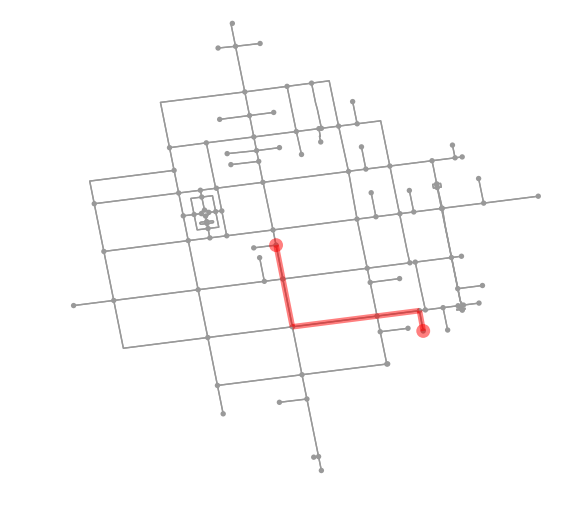

In [6]:
# find the route between these nodes then plot it
route = nx.shortest_path(G, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G, route)

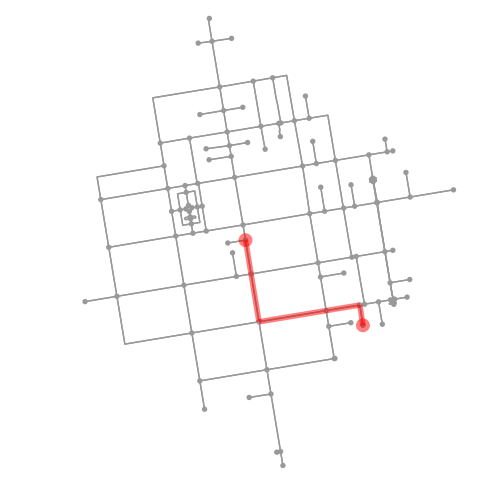

In [7]:
# project the network to UTM (zone calculated automatically) then plot the network/route again
G_proj = ox.project_graph(G)
fig, ax = ox.plot_graph_route(G_proj, route)

## Plot network path from one lat-long to another

In [8]:
# define origin/desination points then get the nodes nearest to each
origin_point = (37.792896, -122.412325)
destination_point = (37.790495, -122.408353)
origin_node = ox.get_nearest_node(G, origin_point)
destination_node = ox.get_nearest_node(G, destination_point)
origin_node, destination_node

(850803362, 65290756)

In [9]:
# find the shortest path between origin and destination nodes
route = nx.shortest_path(G, origin_node, destination_node, weight='length')
str(route)

'[850803362, 633686735, 633686762, 633686748, 633686743, 850803353, 65295320, 65295314, 65295311, 65332818, 65332815, 65319944, 65290756]'

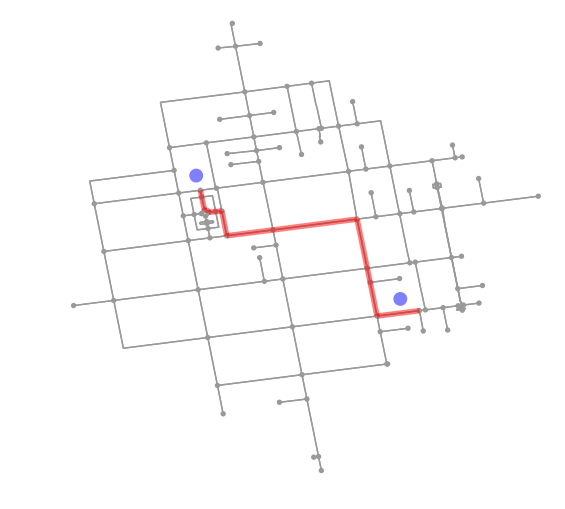

In [10]:
# plot the route showing origin/destination lat-long points in blue
fig, ax = ox.plot_graph_route(G, route, origin_point=origin_point, destination_point=destination_point)

## Demonstrate routing with one-way streets

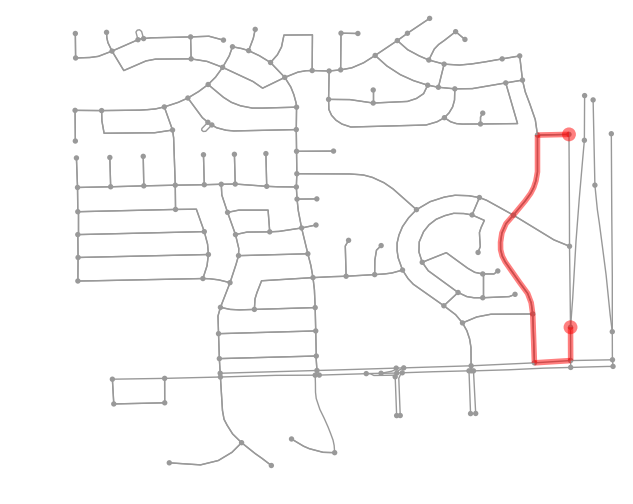

In [11]:
G = ox.graph_from_address('N. Corsica Pl., Chandler, Arizona', distance=800, network_type='drive')
origin = (33.307792, -111.894940)
destination = (33.312994, -111.894998)
origin_node = ox.get_nearest_node(G, origin)
destination_node = ox.get_nearest_node(G, destination)
route = nx.shortest_path(G, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G, route, save=True, filename='route')

#### Also, when there are parallel edges between nodes in the route, OSMnx picks the shortest edge to plot

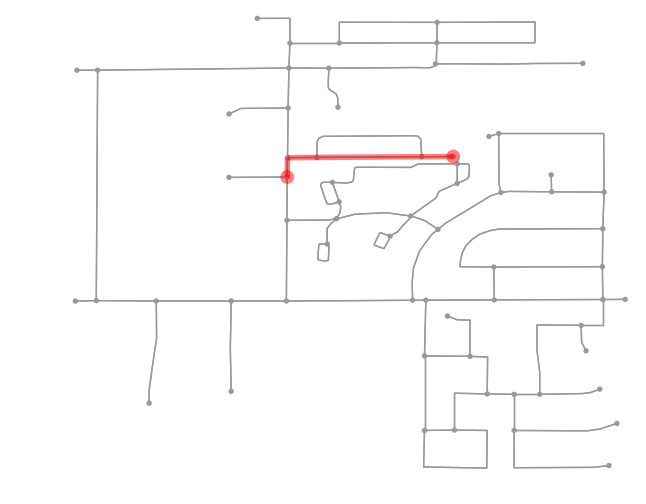

In [12]:
location_point = (33.299896, -111.831638)
G = ox.graph_from_point(location_point, distance=500, clean_periphery=False)
origin = (33.301821, -111.829871)
destination = (33.301402, -111.833108)
origin_node = ox.get_nearest_node(G, origin)
destination_node = ox.get_nearest_node(G, destination)
route = nx.shortest_path(G, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G, route)